## Setup

In [1]:
import os
from pymongo import MongoClient
import urllib
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv

In [2]:
# set this option to wrap wide columns
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', None)

### Load data

In [3]:
load_dotenv()

try:
    username = urllib.parse.quote_plus(os.getenv('MONGO_USERNAME'))
    password = urllib.parse.quote_plus(os.getenv('MONGO_PASSWORD'))
    host = os.getenv('MONGO_HOST')
except TypeError:
    print('Please set environment variables first!')
    raise TypeError

myClient = MongoClient(f'mongodb+srv://{username}:{password}@{host}/?retryWrites=true&w=majority')

In [4]:
def read_mongo(db, collection, query={}, no_id=True):
    mydb = myClient[db]
    col = mydb[collection]

    cursor = col.find()
    raw_df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del raw_df['_id']

    return raw_df

In [5]:
raw_df = read_mongo('myDB', 'data')

In [6]:
raw_df.head(3)

,ticket_id,type,organization,comment,photo,photo_after,coords,address,subdistrict,district,province,timestamp,state,star,count_reopen,last_activity
0,2022-NHRQWA,[จราจร],[เขตห้วยขวาง],รถติดนานแล้ว,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/fed40a2f1defef293b0109a88ee31a55cd325e13.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-08/7c8ecfb6290d1db4bb2d68c5c79738e44bdf405b.jpg,"[100.56405, 13.75106]",46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,บางกะปิ,ห้วยขวาง,กรุงเทพมหานคร,2022-07-01 00:01:11.529841+00,เสร็จสิ้น,5.0,NaN,2022-08-01 14:19:25.174322+00
1,2022-D8TD2Q,[ถนน],[เขตคลองสามวา],ถนนพัง,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/dd8532c024893a3a3ee5f127e1bd498711f94606.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-12/c26589705d0e8b60237a6c665c3de46505a5bde6.jpg,"[100.69372, 13.89715]",26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,สามวาตะวันตก,คลองสามวา,กรุงเทพมหานคร,2022-07-01 00:01:56.896927+00,เสร็จสิ้น,NaN,NaN,2022-12-13 07:38:21.633096+00
2,2022-E9GUYK,[ถนน],"[เขตคลองเตย, สำนักการโยธา กทม.]",ถนนชำรุด,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/07d9586ea2945e82f8af12d98d3c7055b3a678f4.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2023-02/1675953454173.jpeg,"[100.55411, 13.71305]",29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,คลองเตย,กรุงเทพมหานคร,2022-07-01 00:03:18.721622+00,เสร็จสิ้น,NaN,NaN,2023-02-09 14:37:35.67893+00


### Data Exploration

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70838 entries, 0 to 70837
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ticket_id      70838 non-null  object 
 1   type           70838 non-null  object 
 2   organization   70838 non-null  object 
 3   comment        70838 non-null  object 
 4   photo          70818 non-null  object 
 5   photo_after    63713 non-null  object 
 6   coords         70838 non-null  object 
 7   address        70838 non-null  object 
 8   subdistrict    70838 non-null  object 
 9   district       70838 non-null  object 
 10  province       70838 non-null  object 
 11  timestamp      70838 non-null  object 
 12  state          70838 non-null  object 
 13  star           37962 non-null  float64
 14  count_reopen   40485 non-null  float64
 15  last_activity  70838 non-null  object 
dtypes: float64(2), object(14)
memory usage: 8.6+ MB


In [8]:
raw_df[['address', 'district', 'province']].head(3)

,address,district,province
0,46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,ห้วยขวาง,กรุงเทพมหานคร
1,26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,คลองสามวา,กรุงเทพมหานคร
2,29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,กรุงเทพมหานคร


In [9]:
raw_df.head(3)

,ticket_id,type,organization,comment,photo,photo_after,coords,address,subdistrict,district,province,timestamp,state,star,count_reopen,last_activity
0,2022-NHRQWA,[จราจร],[เขตห้วยขวาง],รถติดนานแล้ว,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/fed40a2f1defef293b0109a88ee31a55cd325e13.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-08/7c8ecfb6290d1db4bb2d68c5c79738e44bdf405b.jpg,"[100.56405, 13.75106]",46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,บางกะปิ,ห้วยขวาง,กรุงเทพมหานคร,2022-07-01 00:01:11.529841+00,เสร็จสิ้น,5.0,NaN,2022-08-01 14:19:25.174322+00
1,2022-D8TD2Q,[ถนน],[เขตคลองสามวา],ถนนพัง,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/dd8532c024893a3a3ee5f127e1bd498711f94606.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-12/c26589705d0e8b60237a6c665c3de46505a5bde6.jpg,"[100.69372, 13.89715]",26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,สามวาตะวันตก,คลองสามวา,กรุงเทพมหานคร,2022-07-01 00:01:56.896927+00,เสร็จสิ้น,NaN,NaN,2022-12-13 07:38:21.633096+00
2,2022-E9GUYK,[ถนน],"[เขตคลองเตย, สำนักการโยธา กทม.]",ถนนชำรุด,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-07/07d9586ea2945e82f8af12d98d3c7055b3a678f4.jpg,https://storage.googleapis.com/traffy_public_bucket/attachment/2023-02/1675953454173.jpeg,"[100.55411, 13.71305]",29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,คลองเตย,กรุงเทพมหานคร,2022-07-01 00:03:18.721622+00,เสร็จสิ้น,NaN,NaN,2023-02-09 14:37:35.67893+00


In [10]:
raw_df.shape

(70838, 16)

## Data cleaning

In [11]:
cleaned_df = raw_df.copy()
cleaned_df.isna().sum()

ticket_id            0
type                 0
organization         0
comment              0
photo               20
photo_after       7125
coords               0
address              0
subdistrict          0
district             0
province             0
timestamp            0
state                0
star             32876
count_reopen     30353
last_activity        0
dtype: int64

In [12]:
cleaned_df.drop(columns=['ticket_id', 'photo', 'photo_after', 'star', 'count_reopen'], inplace=True)

# view data
display(cleaned_df.shape)
display(cleaned_df.isna().sum())

(70838, 11)

type             0
organization     0
comment          0
coords           0
address          0
subdistrict      0
district         0
province         0
timestamp        0
state            0
last_activity    0
dtype: int64

In [13]:
def extract_coord(coord_series):
    longs = []
    lats = []
    for lo, la in coord_series:
       longs.append(float(lo))
       lats.append(float(la))
    return pd.DataFrame({
        'latitude': lats, 
        'longitude': longs
    }) 

In [14]:
cleaned_df[['latitude', 'longitude']] = extract_coord(cleaned_df.coords)

In [15]:
cleaned_df.head(3)

,type,organization,comment,coords,address,subdistrict,district,province,timestamp,state,last_activity,latitude,longitude
0,[จราจร],[เขตห้วยขวาง],รถติดนานแล้ว,"[100.56405, 13.75106]",46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,บางกะปิ,ห้วยขวาง,กรุงเทพมหานคร,2022-07-01 00:01:11.529841+00,เสร็จสิ้น,2022-08-01 14:19:25.174322+00,13.75106,100.56405
1,[ถนน],[เขตคลองสามวา],ถนนพัง,"[100.69372, 13.89715]",26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,สามวาตะวันตก,คลองสามวา,กรุงเทพมหานคร,2022-07-01 00:01:56.896927+00,เสร็จสิ้น,2022-12-13 07:38:21.633096+00,13.89715,100.69372
2,[ถนน],"[เขตคลองเตย, สำนักการโยธา กทม.]",ถนนชำรุด,"[100.55411, 13.71305]",29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,คลองเตย,กรุงเทพมหานคร,2022-07-01 00:03:18.721622+00,เสร็จสิ้น,2023-02-09 14:37:35.67893+00,13.71305,100.55411


### Processed datetime

In [16]:
cleaned_df['timestamp'] = pd.to_datetime(cleaned_df.timestamp, utc=True)
cleaned_df['last_activity'] = pd.to_datetime(cleaned_df.last_activity, utc=True)

In [17]:
def get_delta_hour(row):
    start = row.timestamp
    end = row.last_activity
    delta = (end - start).total_seconds()
    return round(delta / 3600, 4)

In [18]:
cleaned_df.loc[:, 'hour_spend'] = cleaned_df[['timestamp', 'last_activity']].apply(get_delta_hour, axis=1)
cleaned_df.tail()

,type,organization,comment,coords,address,subdistrict,district,province,timestamp,state,last_activity,latitude,longitude,hour_spend
70833,[เสียงรบกวน],[เขตคันนายาว],ยังมี เสียงรบกวนดังอยู่ #1555 #bkkrongtook,"[100.68933, 13.80303]",78 ราณี 7 ซอย 3 แขวง คันนายาว เขตคันนายาว กรุงเทพมหานคร 10230 ประเทศไทย,คันนายาว,คันนายาว,จังหวัดกรุงเทพมหานคร,2022-12-31 19:45:31.491793+00:00,เสร็จสิ้น,2023-01-11 07:36:42.197438+00:00,13.80303,100.68933,251.8530
70834,[ความสะอาด],"[เขตประเวศ, สำนักสิ่งแวดล้อม กทม.]",เริ่มปีใหม่ 1/1/66 \nตี 2 กับ 51 นาที \nกลิ่นขยะเหม็นยังคงอยู่,"[100.68078, 13.70914]",98/85 เฉลิมพระเกีรยติ ร.9 ซอย 67 แขวง ประเวศ เขต ประเวศ กรุงเทพมหานคร 10250 ประเทศไทย,ประเวศ,ประเวศ,กรุงเทพมหานคร,2022-12-31 19:53:08.438898+00:00,เสร็จสิ้น,2023-01-10 03:20:53.308490+00:00,13.70914,100.68078,223.4625
70835,[ถนน],[เขตป้อมปราบศัตรูพ่าย],ซอย (ไม่ทราบชื่อ) ถนนมังกร เขตป้อมปราบศัตรูพ่าย\nเข้าซอยดังกล่าว (จุดสังเกตเป็นซอยข้างวัดพลับพลาไชย ตรงข้ามอู่รถสามล้อ) บริเวณสุดแนวตรงข้ามวัดพลับพลาไชย พบร้านขายของชำ (ไม่ทราบชื่อ) ตั้งวงดื่มสุรา เปิดเพลง ส่งเสียงดังรบกวน ช่วงเวลาตั้งแต่ 21.00 น. เป็นต้นไป เป็นประจำบ่อยครั้ง #1555 #bkkrongtook,"[100.51280, 13.74480]",203 ถนน มังกร แขวง ป้อมปราบ เขตป้อมปราบศัตรูพ่าย กรุงเทพมหานคร 10100 ประเทศไทย,ป้อมปราบ,ป้อมปราบศัตรูพ่าย,จังหวัดกรุงเทพมหานคร,2022-12-31 20:37:37.226395+00:00,เสร็จสิ้น,2023-01-04 12:05:40.819003+00:00,13.74480,100.51280,87.4677
70836,"[ถนน, เสียงรบกวน]","[เขตบางบอน, เขตภาษีเจริญ]",เปิดเพลงเสียงดังตั้งแต่ตอนเช้าจนถึงตีสี่ยังไม่หยุด เสียงดังรบกวนมากมีลูกเล็กนอนไม่ได้\nเคยโทรหา 191 สามรอบแล้วยังไม่มีเจ้าหน้าที่เข้าไปตรวจดูเลยโทรมาร้องทุกข์ 1555\n\nจุดเกิดเหตุอยู่ตรง ห้างหุ่นส่วนจำกัดบางบอนค้าส่ง ถนนบางบอน 1 แยก 12\n\n #1555 #bkkrongtook,"[100.42785, 13.68924]",บางบอน 1 คลองบางบอน บางบอน กรุงเทพมหานคร,บางหว้า,ภาษีเจริญ,จังหวัดกรุงเทพมหานคร,2022-12-31 20:52:02.074206+00:00,เสร็จสิ้น,2023-01-03 07:32:03.519477+00:00,13.68924,100.42785,58.6671
70837,"[ต้นไม้, ความสะอาด, จราจร]",[เขตคันนายาว],ไม่มีการจัดหรือตัดแต่งต้นไม้ที่ยื่นออกมาบนถนน รถต้องขับชนหรือเบียดกิ่งไม้เหมือนเดิม. ทางแคบเหมือนเดิม กรวยจราจรถูกนำกลับมาตั้งที่เดิมเบียดทางไว้ กั๊กพื้นที่ไว้ ผิด พ.ร.บ. รักษาความสะอาดและความเป็นระเบียบเรียบร้อย,"[100.67610, 13.83646]",120/394 ซ. กาญจนาภิเษก 11/1 แยก 1-1 แขวง คันนายาว เขตคันนายาว กรุงเทพมหานคร 10230 ประเทศไทย,คันนายาว,คันนายาว,กรุงเทพมหานคร,2022-12-31 23:58:12.801312+00:00,เสร็จสิ้น,2023-01-02 02:01:46.088099+00:00,13.83646,100.67610,26.0592


### clean comment text

In [19]:
import re

urlR = r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
hashtagR = r"#[\u0E00-\u0E7Fa-zA-Z]"
emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

def clean_text(text):
    text = re.sub(urlR, ' ', text)
    text = re.sub(hashtagR, '', text)
    text = re.sub(emoj, '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r"[,.;@#?!&$]+\ *", " ", text)
    return text.strip()

In [20]:
cleaned_df['comment'] = cleaned_df['comment'].apply(clean_text)

In [21]:
cleaned_df.head(3)

,type,organization,comment,coords,address,subdistrict,district,province,timestamp,state,last_activity,latitude,longitude,hour_spend
0,[จราจร],[เขตห้วยขวาง],รถติดนานแล้ว,"[100.56405, 13.75106]",46 ถ. อโศก - ดินแดง แขวง บางกะปิ เขตห้วยขวาง กรุงเทพมหานคร 10310 ประเทศไทย,บางกะปิ,ห้วยขวาง,กรุงเทพมหานคร,2022-07-01 00:01:11.529841+00:00,เสร็จสิ้น,2022-08-01 14:19:25.174322+00:00,13.75106,100.56405,758.3038
1,[ถนน],[เขตคลองสามวา],ถนนพัง,"[100.69372, 13.89715]",26/2 ถนน กาญจนาฎเษก แขวง สามวาตะวันตก เขตคลองสามวา กรุงเทพมหานคร 10510 ประเทศไทย,สามวาตะวันตก,คลองสามวา,กรุงเทพมหานคร,2022-07-01 00:01:56.896927+00:00,เสร็จสิ้น,2022-12-13 07:38:21.633096+00:00,13.89715,100.69372,3967.6069
2,[ถนน],"[เขตคลองเตย, สำนักการโยธา กทม.]",ถนนชำรุด,"[100.55411, 13.71305]",29 ถนน เชื้อเพลิง แขวง คลองเตย เขตคลองเตย กรุงเทพมหานคร 10110 ประเทศไทย,คลองเตย,คลองเตย,กรุงเทพมหานคร,2022-07-01 00:03:18.721622+00:00,เสร็จสิ้น,2023-02-09 14:37:35.678930+00:00,13.71305,100.55411,5366.5714


In [23]:
save_df = cleaned_df.drop(columns=['address', 'last_activity', 'state', 'coords'])
save_df.to_csv('data/cleaned_bangkok_traffy.csv', index=False)

## EDA

In [3]:
import seaborn as sns
from sklearn import preprocessing
import math

In [4]:
cleaned_df = pd.read_csv('data/cleaned_bangkok_traffy.csv', parse_dates=["timestamp"])
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70838 entries, 0 to 70837
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   type          70838 non-null  object             
 1   organization  70838 non-null  object             
 2   comment       70832 non-null  object             
 3   subdistrict   70838 non-null  object             
 4   district      70838 non-null  object             
 5   province      70838 non-null  object             
 6   timestamp     70838 non-null  datetime64[ns, UTC]
 7   latitude      70838 non-null  float64            
 8   longitude     70838 non-null  float64            
 9   hour_spend    70838 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(3), object(6)
memory usage: 5.4+ MB


Text(0.5, 1.0, 'Box plots for min-max scaled features')

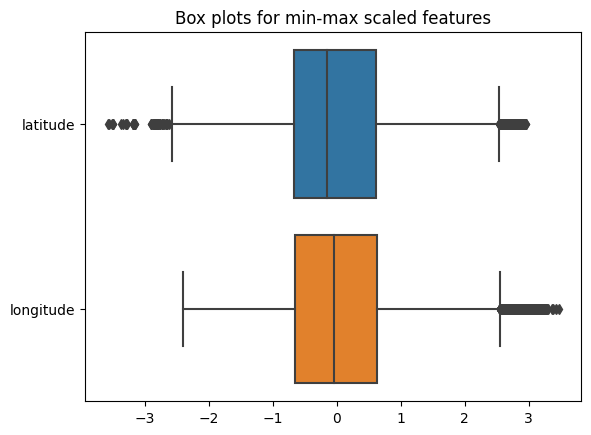

In [5]:
standard_scaler = preprocessing.StandardScaler()

numerical_features = ['latitude','longitude']

dataScaled = pd.DataFrame(standard_scaler.fit_transform(cleaned_df[numerical_features]), columns=numerical_features)
#viz_2=sns.violinplot(data=data, y=['price','number_of_reviews'])
ax = sns.boxplot(data=dataScaled, orient="h")
ax.set_title("Box plots for min-max scaled features")

Latitude skewness: 0.43
Longitude skewness: 0.27


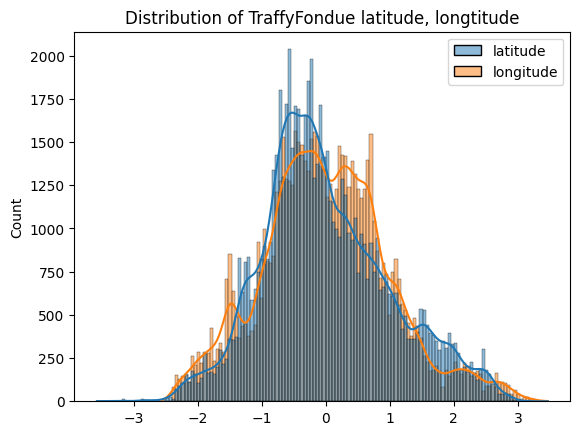

In [6]:
sns.histplot(dataScaled[['latitude', 'longitude']], kde=True).set_title("Distribution of TraffyFondue latitude, longtitude")
print("Latitude skewness: %.2f"%(dataScaled['latitude'].skew()))
print("Longitude skewness: %.2f"%(dataScaled['longitude'].skew()))

Skewness: 1.57


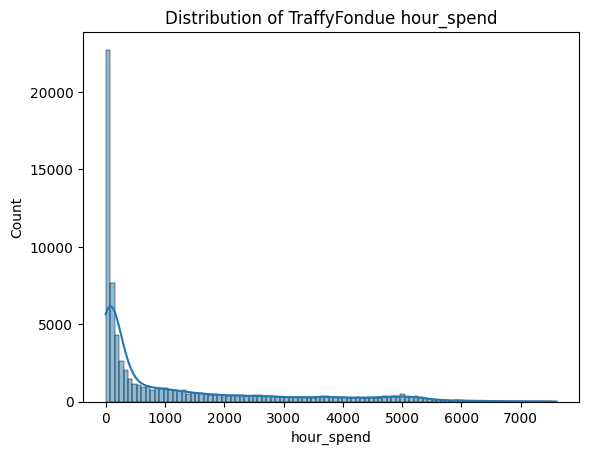

In [7]:
sns.histplot(cleaned_df['hour_spend'], kde=True).set_title("Distribution of TraffyFondue hour_spend")
print("Skewness: %.2f"%(cleaned_df['hour_spend'].skew()))

In [8]:
cleaned_df['hour_spend_log1p'] = cleaned_df['hour_spend'].apply(math.log1p)

Text(0.5, 1.0, 'Box plots for min-max scaled hour_spend')

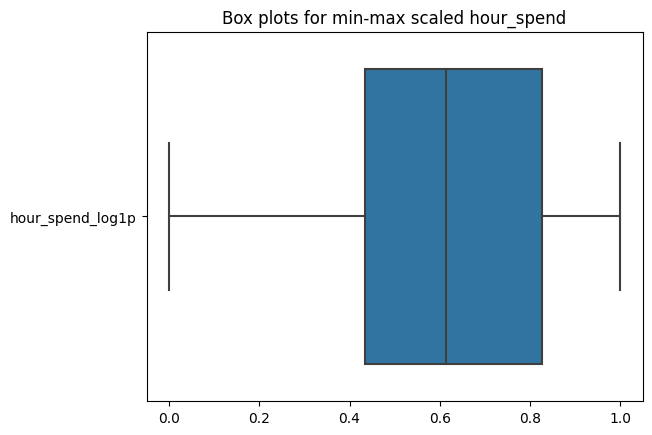

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()

hour_spend_log_scaled = pd.DataFrame(min_max_scaler.fit_transform(cleaned_df[['hour_spend_log1p']]), columns=['hour_spend_log1p'])
ax = sns.boxplot(data=hour_spend_log_scaled, orient="h")
ax.set_title("Box plots for min-max scaled hour_spend")

Skewness: -0.33


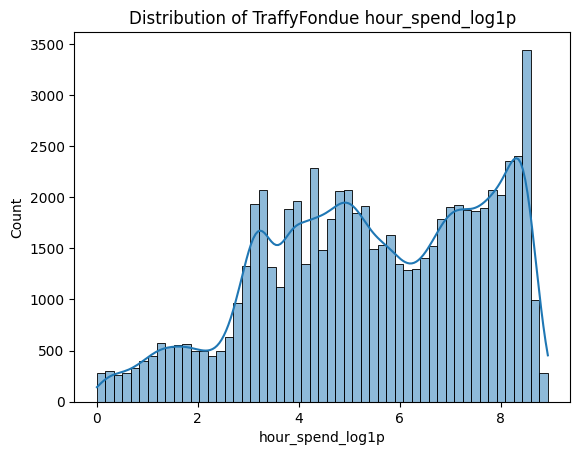

In [10]:
sns.histplot(cleaned_df['hour_spend_log1p'], kde=True).set_title("Distribution of TraffyFondue hour_spend_log1p")
print("Skewness: %.2f"%(cleaned_df['hour_spend_log1p'].skew()))

## feature engineering

### tranforms organization and type

In [11]:
import scipy
from sklearn.model_selection import train_test_split

In [12]:
def extract_set(data):
    data = data.strip('[]').split(', ')
    return {v.strip("''") for v in data}

In [13]:
cleaned_df['type_set'] = cleaned_df['type'].apply(extract_set)
cleaned_df['organization_set'] = cleaned_df['organization'].apply(extract_set)

In [14]:
type_mlb = preprocessing.MultiLabelBinarizer(sparse_output=True)
org_mlb = preprocessing.MultiLabelBinarizer(sparse_output=True)

type_features = type_mlb.fit_transform(cleaned_df['type_set'])
org_features = org_mlb.fit_transform(cleaned_df['organization_set'])

In [15]:
print(type_mlb.classes_)
print('')
print(org_mlb.classes_)

['PM2.5' 'การเดินทาง' 'กีดขวาง' 'คนจรจัด' 'คลอง' 'ความปลอดภัย' 'ความสะอาด'
 'จราจร' 'ต้นไม้' 'ถนน' 'ทางเท้า' 'ท่อระบายน้ำ' 'น้ำท่วม' 'ป้าย'
 'ป้ายจราจร' 'ร้องเรียน' 'สอบถาม' 'สะพาน' 'สัตว์จรจัด' 'สายไฟ' 'ห้องน้ำ'
 'เสนอแนะ' 'เสียงรบกวน' 'แสงสว่าง']

['สำนักการคลัง กทม.' 'สำนักการจราจรและขนส่ง กรุงเทพมหานคร (สจส.)'
 'สำนักการระบายน้ำ กทม.' 'สำนักการวางผังและพัฒนาเมือง กทม.'
 'สำนักการศึกษา กทม.' 'สำนักการแพทย์ กทม.' 'สำนักการโยธา กทม.'
 'สำนักงบประมาณกรุงเทพมหานคร' 'สำนักงานคณะกรรมการข้าราชการกรุงเทพมหานคร'
 'สำนักป้องกันและบรรเทาสาธารณภัย กทม.' 'สำนักพัฒนาสังคม กทม.'
 'สำนักยุทธศาสตร์และประเมินผล กทม.'
 'สำนักวัฒนธรรม กีฬาและการท่องเที่ยว กทม.' 'สำนักสิ่งแวดล้อม กทม.'
 'สำนักอนามัย กทม.' 'สำนักเทศกิจ กทม.' 'เขตคลองสาน' 'เขตคลองสามวา'
 'เขตคลองเตย' 'เขตคันนายาว' 'เขตจตุจักร' 'เขตจอมทอง' 'เขตดอนเมือง'
 'เขตดินแดง' 'เขตดุสิต' 'เขตตลิ่งชัน' 'เขตทวีวัฒนา' 'เขตทุ่งครุ'
 'เขตธนบุรี' 'เขตบางกอกน้อย' 'เขตบางกอกใหญ่' 'เขตบางกะปิ' 'เขตบางขุนเทียน'
 'เขตบางคอแหลม' 'เขตบางซื่อ' 'เขตบางนา' 'เขตบางบอ

In [16]:
type_features.shape, org_features.shape

((70838, 24), (70838, 72))

In [43]:
rand_seed = 54

numerical_feature_names = ['latitude','longitude']
numerical_features = cleaned_df[numerical_feature_names]
scaler = preprocessing.StandardScaler()
numerical_features = scaler.fit_transform(numerical_features)

features = scipy.sparse.hstack((numerical_features, type_features, org_features),format='csr')
all_feature_names = np.hstack((numerical_feature_names, type_mlb.classes_, org_mlb.classes_))

target = cleaned_df['hour_spend'].values
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rand_seed)

### tranform text

In [30]:
# text processing
from sklearn.feature_extraction.text import CountVectorizer
from pythainlp import word_tokenize

In [31]:
# Same train-test split as before (same random seed)
text_train, text_test = train_test_split(cleaned_df['comment'], test_size=0.2, random_state=rand_seed)

training_corpus = text_train.values.astype('U')
vectorizer = CountVectorizer(min_df=5, tokenizer=word_tokenize, analyzer='word') 
# min_df is the minimum number of times a word needs to appear in the corpus in order to be assigned a vector
vectorizer.fit(training_corpus)
num_words = len(vectorizer.vocabulary_) # Total number of words 
print("Number of distinct words to be used as features:", num_words)

d:\Projects\DS2022-2_TraffyFondue_Project_ML\env\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of distinct words to be used as features: 8243


In [32]:
full_corpus = cleaned_df['comment'].values.astype('U')
word_features = vectorizer.transform(full_corpus) # This is a sparse matrix of our word-occurrence features 
words = vectorizer.get_feature_names_out() # The actual words corresponding to the columns of the above feature matrix
word_frequencies = np.array(word_features.sum(axis=0))[0] # The term frequency of each word in the dataset
print("Shape of word-occurrence feature matrix:",word_features.shape)

Shape of word-occurrence feature matrix: (70838, 8243)


In [44]:
num_non_text = features.shape[1]
features_with_text = scipy.sparse.hstack((features, word_features),format='csr') 
# We want to keep the feature matrix in a sparse format for efficiency
feature_names = np.hstack((all_feature_names, words))   

# Same train-test split as before (same random seed)
features_with_text_train, features_with_text_test, target_train, target_test = train_test_split(
    features_with_text, target, test_size=0.2, random_state=rand_seed)

num_features = num_non_text + num_words

print("Number of non-text features: ",num_non_text)
print("Number of vectorized text features (word occurrences): ",num_words)
print("Features shape including text features: ",features_with_text.shape)

Number of non-text features:  98
Number of vectorized text features (word occurrences):  8243
Features shape including text features:  (70838, 8341)


### Model

In [45]:
from sklearn.linear_model import RidgeCV

In [52]:
%%time
from sklearn import linear_model

ridge_fit = linear_model.RidgeCV(cv=5)
ridge_fit.fit(features_train, target_train)
print("RidgeCV found an optimal regularization parameter alpha =",ridge_fit.alpha_)
train_score_no_text = ridge_fit.score(features_train, target_train)
test_score_no_text = ridge_fit.score(features_test,target_test)
print("Train score for Ridge Regression without text features:", train_score_no_text)
print("Test score for Ridge Regression without text features:", test_score_no_text)

RidgeCV found an optimal regularization parameter alpha = 0.1
Train score for Ridge Regression without text features: 0.3800698800461412
Test score for Ridge Regression without text features: 0.37589745102709404
CPU times: total: 1.58 s
Wall time: 1.62 s


In [54]:
%%time
ridge_w_text = RidgeCV(cv=5)
ridge_w_text.fit(features_with_text_train, target_train)
print("RidgeCV found an optimal regularization parameter alpha =",ridge_fit.alpha_)
train_score_with_text = ridge_w_text.score(features_with_text_train, target_train)
test_score_with_text = ridge_w_text.score(features_with_text_test, target_test)
print("Train score for Ridge Regression WITH text features:", train_score_with_text)
print("Test score for Ridge Regression WITH text features:", test_score_with_text)

RidgeCV found an optimal regularization parameter alpha = 0.1
Test score for Ridge Regression WITHOUT text features: 0.48002627788843666
Test score for Ridge Regression WITH text features: 0.3538462635768094
CPU times: total: 44.6 s
Wall time: 44.7 s


In [70]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=200, 
                                min_samples_leaf=5,
                                max_features=0.3,
                                max_depth=24,
                                n_jobs=4)

In [71]:
%%time
regr.fit(features_train, target_train)
train_score_no_text = regr.score(features_train, target_train)
test_score_no_text = regr.score(features_test, target_test)
print("Train score for Ridge Regression WITHOUT text features:", train_score_no_text)
print("Test score for Ridge Regression WITHOUT text features:", test_score_no_text)

Train score for Ridge Regression WITHOUT text features: 0.547943474997095
Test score for Ridge Regression WITHOUT text features: 0.46212500484293506
CPU times: total: 1min 18s
Wall time: 19.9 s


In [74]:
regr2 = RandomForestRegressor(n_estimators=200, 
                                min_samples_leaf=5,
                                max_features=0.3,
                                max_depth=24,
                                n_jobs=4)

In [75]:
regr2.fit(features_with_text_train, target_train)
train_score_text = regr2.score(features_with_text_train, target_train)
test_score_text = regr2.score(features_with_text_test, target_test)
print("Train score for Ridge Regression WITH text features:", train_score_text)
print("Test score for Ridge Regression WITH text features:", test_score_text)

Train score for Ridge Regression WITH text features: 0.595174725047691
Test score for Ridge Regression WITH text features: 0.4671196774123062


### Evaluation

In [48]:
from sklearn.metrics import mean_squared_error, r2_score

In [49]:
y_pred = ridge_fit.predict(features_test)
score = r2_score(target_test, y_pred)
mse = mean_squared_error(target_test, y_pred)

print("R-squared:", score) 
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

R-squared: 0.37589745102709404
MSE:  1543333.3552018
RMSE:  1242.309685707151


In [76]:
y_pred = regr.predict(features_test)
score = r2_score(target_test, y_pred)
mse = mean_squared_error(target_test, y_pred)

print("R-squared:", score) 
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

R-squared: 0.46212500484293506
MSE:  1330102.5966342315
RMSE:  1153.3007398914783
